# HOMEWORK 1 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Regression task

## Imports and initializations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
import pickle

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Dataset

In the following cell I just get the datasets for the regression task, load them, get a sample, and plot the 2 datasets.

--2022-01-08 23:16:32--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3,7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.81’

train_data.csv.81   100%[===================>]   3,69K  --.-KB/s    in 0s      

2022-01-08 23:16:33 (25,0 MB/s) - ‘regression_dataset/train_data.csv.81’ saved [3776/3776]

--2022-01-08 23:16:33--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3,7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv.81’

test_

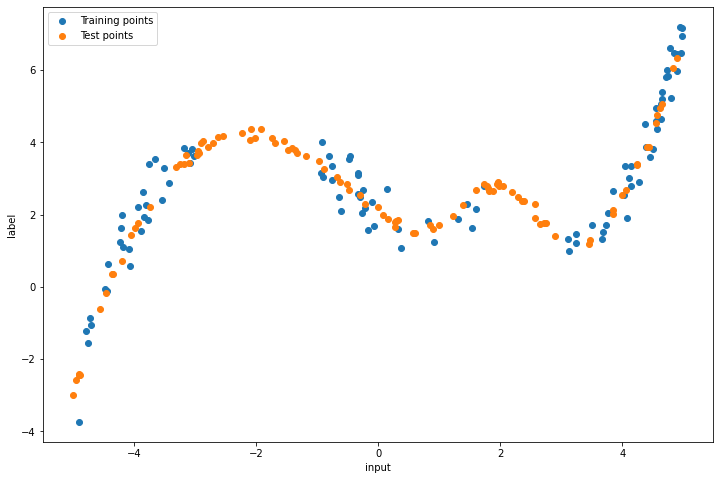

Train set size: 100
Test set size: 100


In [2]:
### Dataset loading
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

#load the datasets
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

#plot train (+validation) set
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
#plot test set on the same plot
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.legend()
plt.show()

print(f'Train set size: {train_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

### Train data
with open('train_data.csv', 'w') as f:
    #write the header
    f.write('input,label\n')
    data = [f"{x},{y}" for x, y in zip(train_df.input, train_df.label)]
    f.write('\n'.join(data))
    #write footer
    f.write('\n')
    
### Test data
with open('test_data.csv', 'w') as f:
    #write the header
    f.write('input,label\n')
    data = [f"{x},{y}" for x, y in zip(test_df.input, test_df.label)]
    f.write('\n'.join(data))
    #write footer
    f.write('\n')


In [3]:
# Dataset 
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        # remove header and footer
        lines = lines[1:-1]
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

# simple pytorch tensor conversion
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

composed_transform = transforms.Compose([ToTensor()])

# create the dataset
train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('test_data.csv', transform=composed_transform)


From the plot it's very noticeable that the training points are not sampled in the same way of the test points, for example, around -2 and +2 there are 2 "blank" spots, with no samples whatsoever, moreover the samples in the training set seem to have an higher variance. The model will need to be able to generalize. 

## Neural Network Architecture

Define a fully connected feed-forward network, different architectures will be considered, different activation functions will be considered in the hidden layers, no activation function will be considered for the output layer since we are dealing with a regression problem and we don't want to limit the output.

In [4]:
### @add DROPOUT LAYERS
#basic 2-layer network with 2 hidden layers, sigmoid activation function
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, activation_fn=nn.Sigmoid(), droput_rate=0):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.dp1 = nn.Dropout(p=droput_rate)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.dp2 = nn.Dropout(p=droput_rate)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = activation_fn
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

### Helper functions   

In [5]:
#useful functions
def plot_save_losses_and_output(val_losses, net, title):
    #first subplot
    fig = plt.figure(figsize=(15,3))
    #set title 
    plt.suptitle(title)
    p1 = plt.subplot(1, 2, 1)
    p1.plot(val_losses, label="Validation loss")
    p1.set_xlabel("Epochs")
    p1.set_ylabel("Loss")
    p1.set_ylim(0, 2)
    p1.legend()

    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device)
    x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

    net.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = net(x_vec)

    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    p2 = plt.subplot(1, 2, 2)
    #show the points from the test dataset
    p2.scatter(test_df.input, test_df.label, label='Test points')
    # learnt function
    p2.plot(x_vec, y_vec, label='Network output', color='red')

    #plt.plot(x_vec, true_model, label='True model')
    p2.set_xlabel('x')
    p2.set_ylabel('y')
    plt.grid()
    plt.legend()
    plt.show()
    #save fig
    fig.savefig(f'images/{title}.eps', format='eps', dpi=1000, bbox_inches='tight')
    plt.close()


def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

## Hyperparamters tuning using cross validation

In [6]:
### TRAINING FUNCTION
def train_model(net, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs=1, enable_early_stopping=True):
    net = net.to(device)
    train_loss_log = []
    val_loss_log = []
    min_validation_loss = float('inf')
    early_stopping_counter = 0
    for epoch_num in tqdm(range(num_epochs)):

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            net.zero_grad() # Zero the gradients
            loss.backward() # Compute the gradients

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()  # .detach() to avoid keeping the gradient in memory
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        # print(f'Train loss: {train_loss}')
        train_loss_log.append(train_loss)

        ### VALIDATION
        if val_dataloader is not None:
            net.eval()
            val_loss= []
            net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_dataloader:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    # Forward pass
                    out = net(x_batch)

                    # Compute loss
                    loss = loss_fn(out, label_batch)

                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)

                # Save average validation loss
                val_loss = np.mean(val_loss)
                # print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                val_loss_log.append(val_loss)

                ## early stopping
                if enable_early_stopping and epoch_num > 10:
                    curr_mean = np.mean(val_loss_log[-10:])
                    if val_loss < min_validation_loss:
                        min_validation_loss = curr_mean
                        torch.save(net.state_dict(), 'training/best_regression_val_model.pt')
                    if curr_mean > 1.1*min_validation_loss:
                        early_stopping_counter += 1
                        if early_stopping_counter > 5:
                            early_stopping_counter += 1
                            print("Early stopping")
                            #load previous best model
                            net.load_state_dict(torch.load('training/best_regression_val_model.pt'))
                            break
                    else:
                        early_stopping_counter = 0
                
    return train_loss_log, val_loss_log, net

In [7]:
### Cross validation training
torch.manual_seed(42)
## paramters
#batch size
batch_sizes = [8]
#activation function
activation_fns = [nn.Tanh(), nn.Sigmoid()] # [nn.Sigmoid(), nn.Tanh(), nn.ReLU(), nn.Softplus()]
activation_fns_strings = ['Tanh', 'Sigmoid'] #['Sigmoid', 'Tanh', 'ReLU', 'Softplus']
#loss function
loss_fns = [nn.L1Loss(), nn.MSELoss()] #[nn.L1Loss(), nn.HuberLoss(), nn.MSELoss()]
loss_fns_strings = ['L1', 'MSE'] #['L1', 'Huber', 'MSE']
#learning rate
learning_rates = [10e-3,7e-3, 4e-3, 1e-3, 0.8e-3] ##= [15e-3, 10e-3, 8e-3, 3e-3, 1e-3, 5e-4]
# number of hidden layers
hidden_layers = [16, 32]
#optimizer
optimizers = [] # will be filled later inside the loop
optimizers_strings = ['SGDMomentum', 'Adam'] # ['SGD', 'SGDMomentum', 'Adam']
#number of epochs
num_epochs = 1000
#k-folds
k_folds = 4

_____________________1/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.01, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:18<00:00, 54.60it/s]


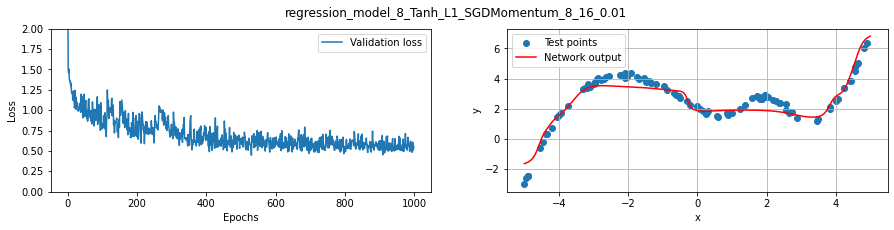

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________2/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.01, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:23<00:00, 42.95it/s]


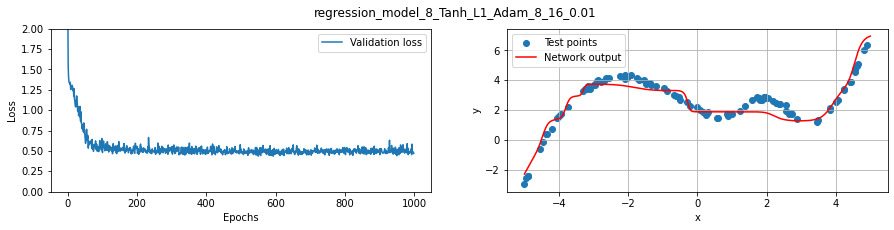

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________3/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.01, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:18<00:00, 53.81it/s]


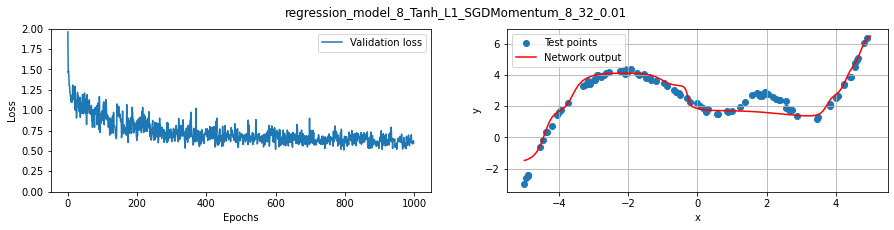

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________4/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.01, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:23<00:00, 43.44it/s]


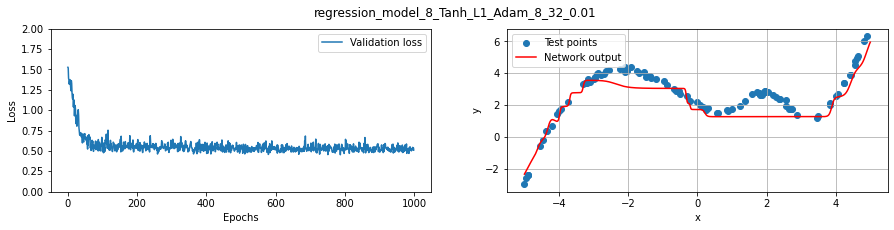

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________5/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.007, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:18<00:00, 54.27it/s]


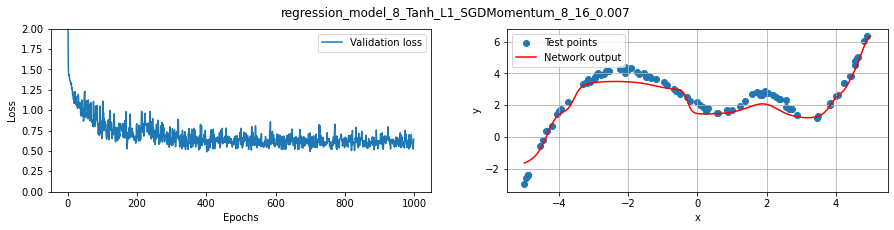

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________6/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.007, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:23<00:00, 42.80it/s]


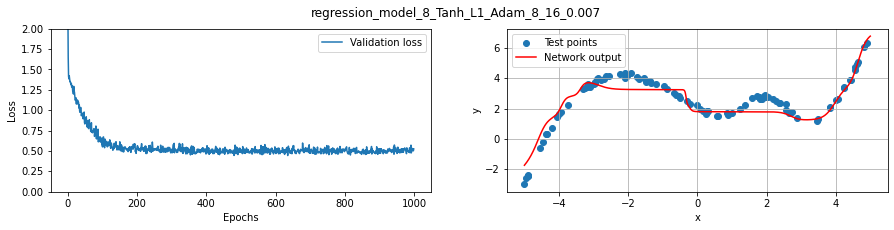

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________7/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.007, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:19<00:00, 50.89it/s]


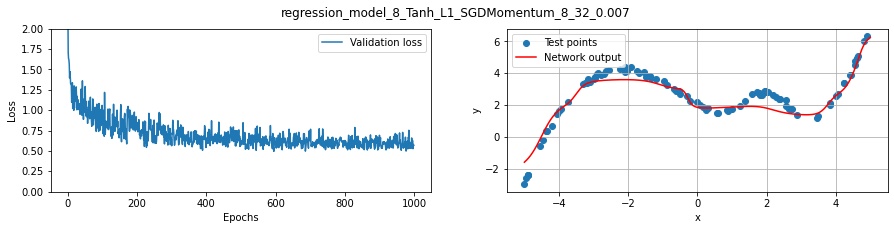

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________8/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.007, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s]


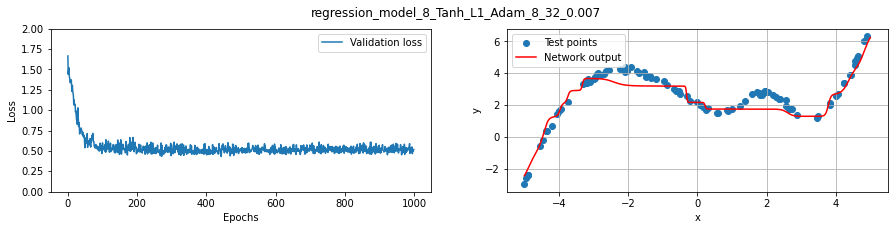

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________9/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.004, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:17<00:00, 58.07it/s]


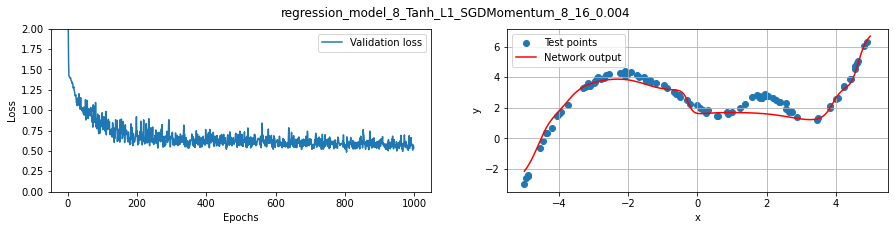

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________10/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.004, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.23it/s]


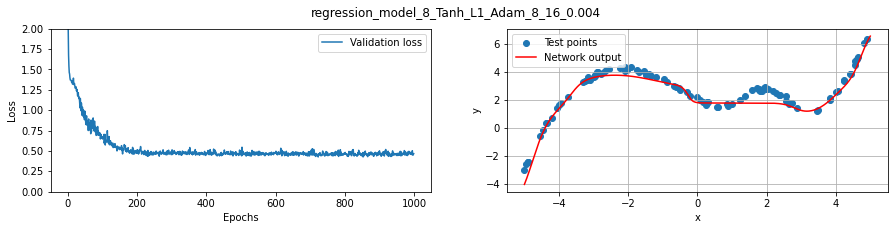

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________11/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.004, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.95it/s]


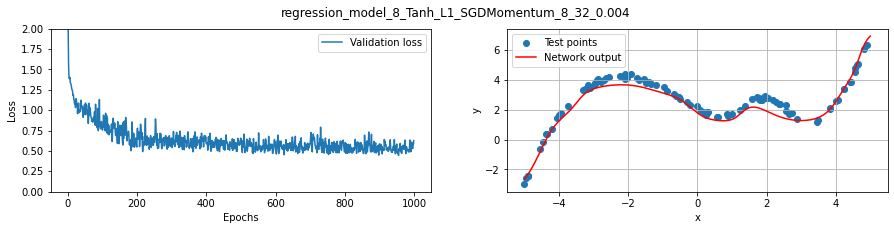

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________12/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.004, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.01it/s]


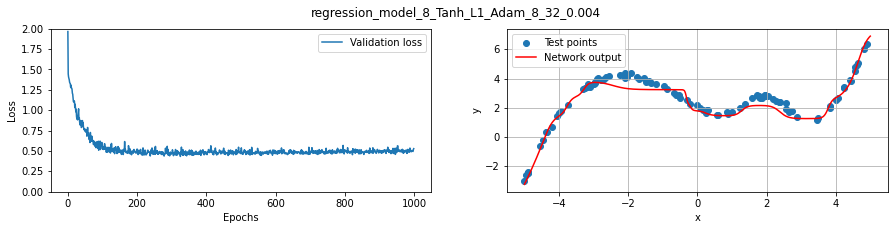

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________13/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.001, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.81it/s]


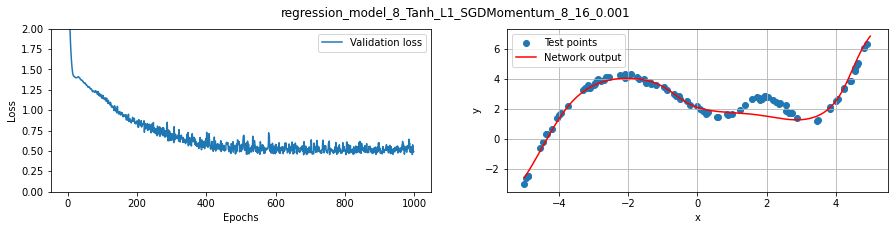

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________14/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.001, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.68it/s]


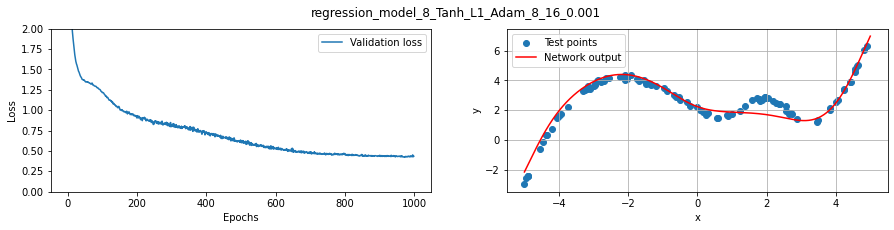

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________15/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.001, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.85it/s]


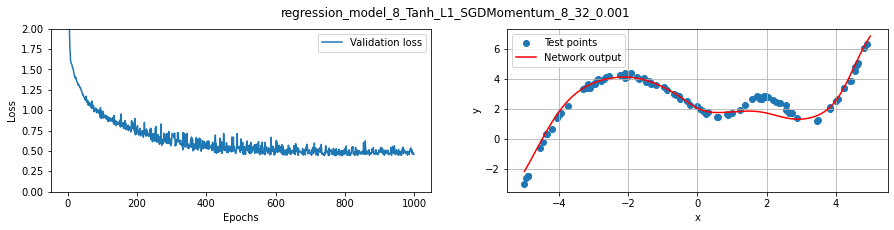

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________16/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.001, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 54.53it/s]


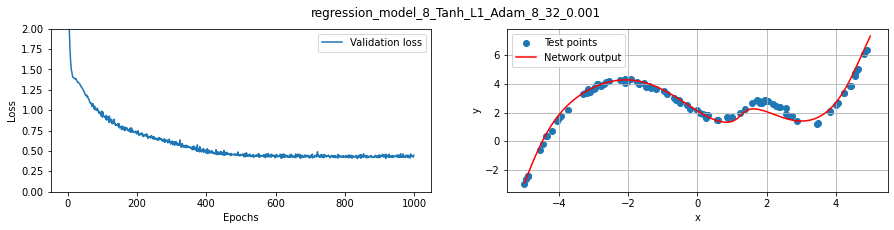

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________17/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.0008, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.64it/s]


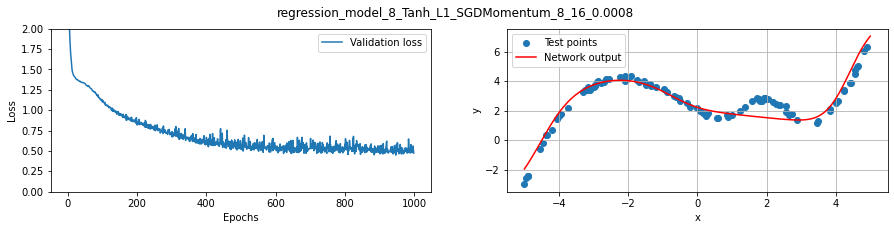

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________18/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.0008, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.05it/s]


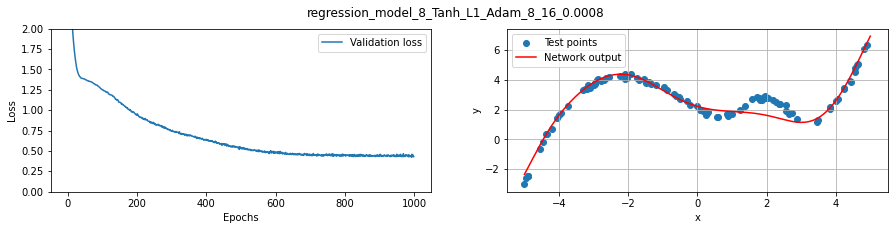

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________19/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.0008, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 70.58it/s]


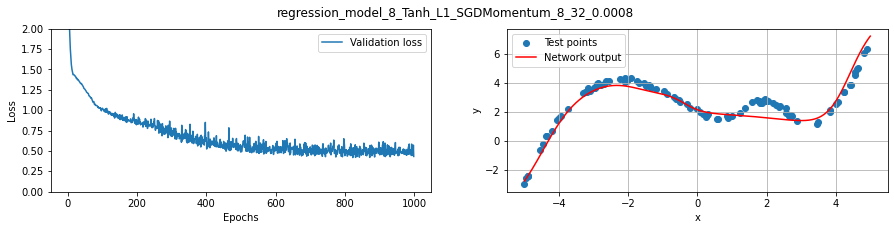

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________20/80____________________
bs: 8, act_fn: Tanh, loss_fn: L1, lr: 0.0008, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.90it/s]


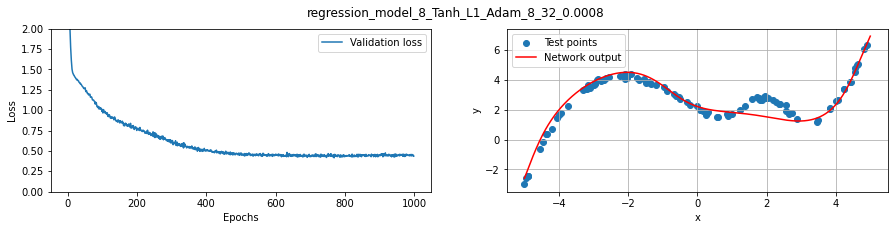

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________21/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.01, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.80it/s]


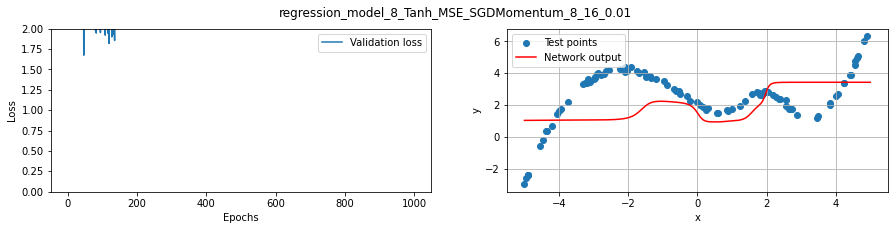

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________22/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.01, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.44it/s]


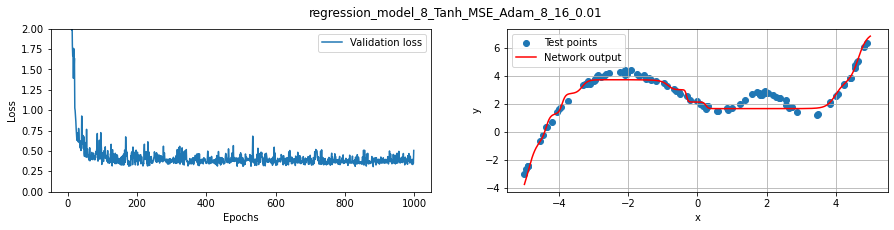

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________23/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.01, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.53it/s]


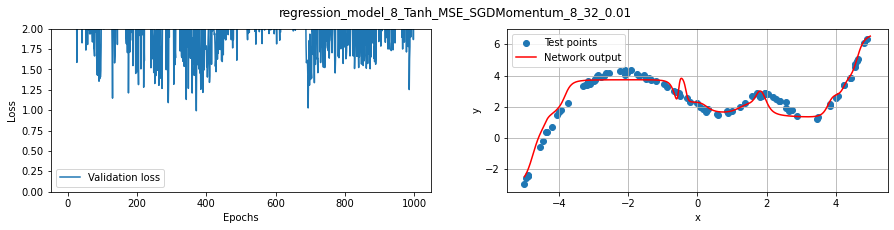

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________24/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.01, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.47it/s]


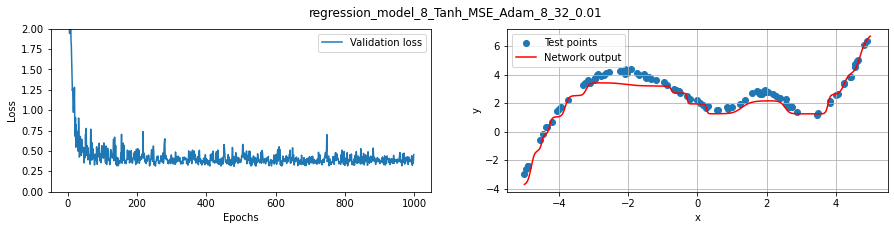

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________25/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.007, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.04it/s]


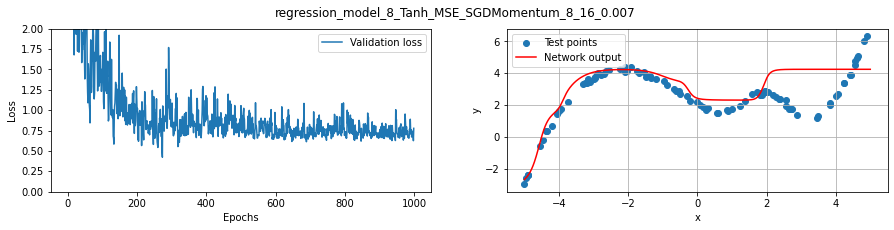

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________26/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.007, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.82it/s]


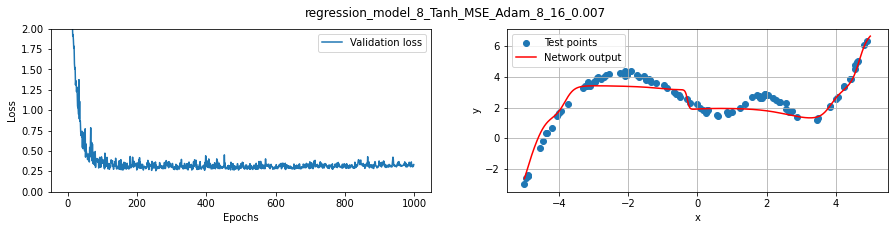

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________27/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.007, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.16it/s]


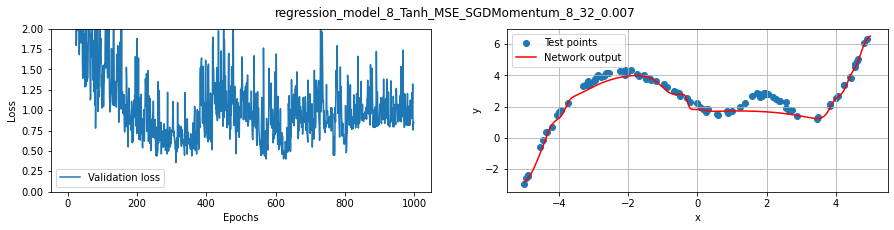

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________28/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.007, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.32it/s]


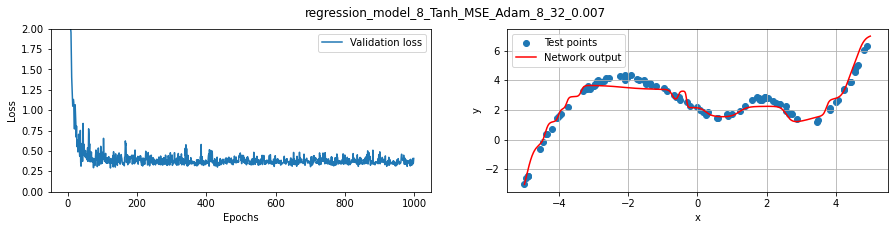

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________29/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.004, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.78it/s]


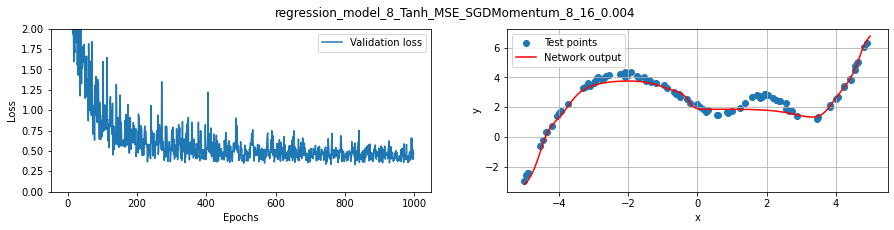

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________30/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.004, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.66it/s]


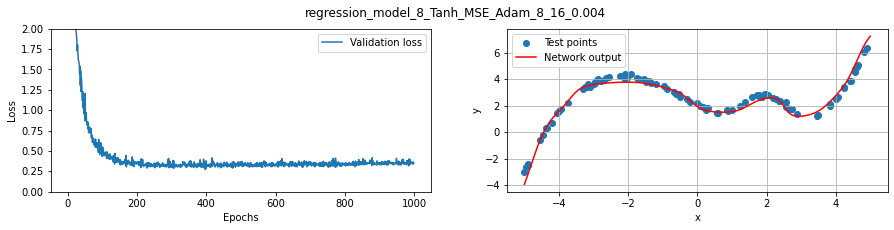

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________31/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.004, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.59it/s]


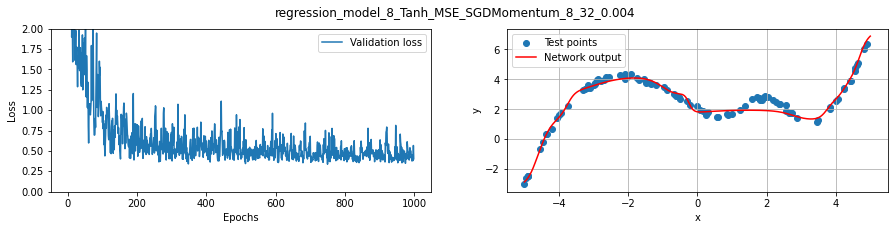

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________32/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.004, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.75it/s]


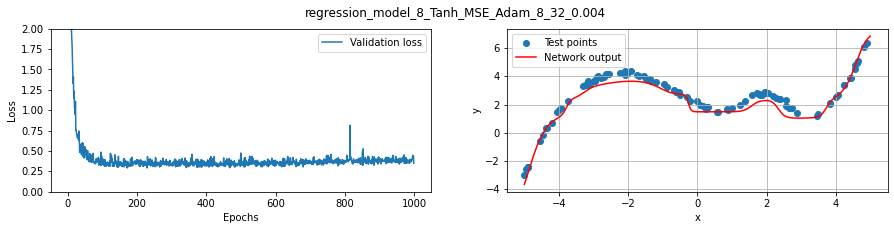

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________33/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.001, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.37it/s]


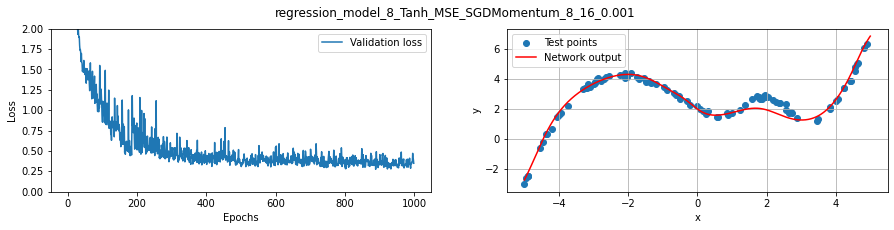

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________34/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.001, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.20it/s]


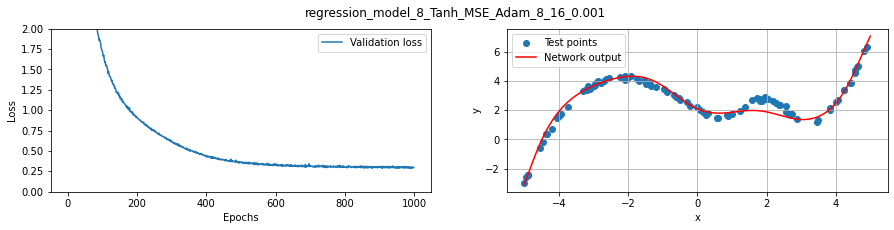

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________35/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.001, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 71.26it/s]


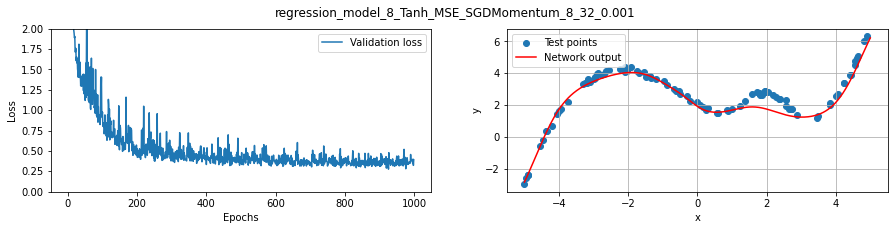

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________36/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.001, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.13it/s]


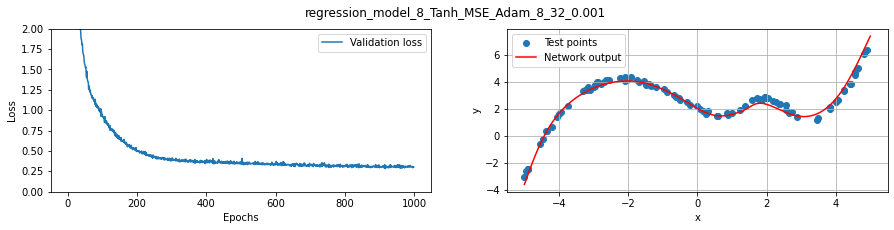

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________37/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.0008, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.53it/s]


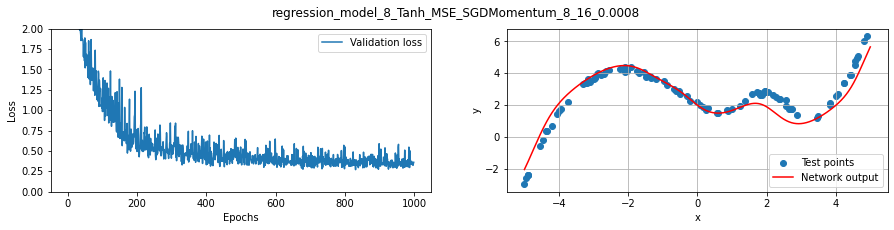

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________38/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.0008, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.35it/s]


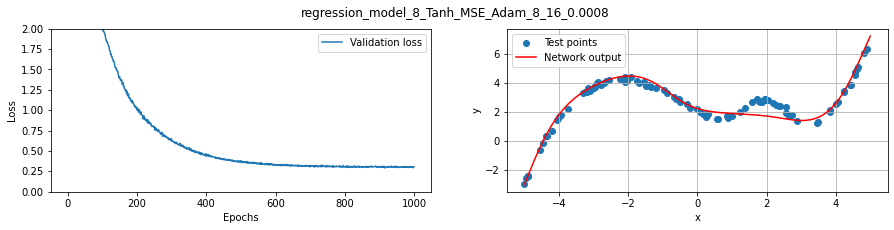

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________39/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.0008, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 70.81it/s]


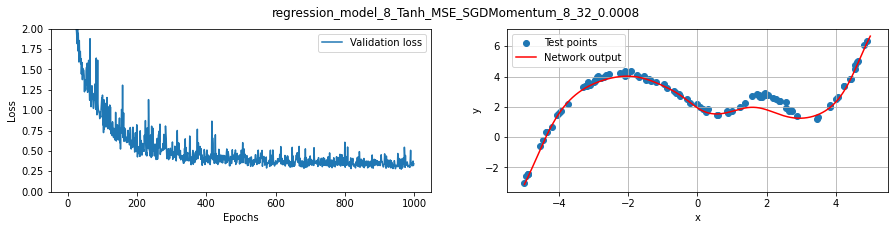

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________40/80____________________
bs: 8, act_fn: Tanh, loss_fn: MSE, lr: 0.0008, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.62it/s]


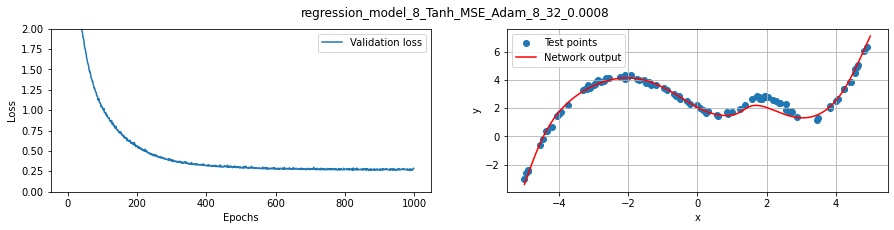

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________41/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.01, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 68.16it/s]


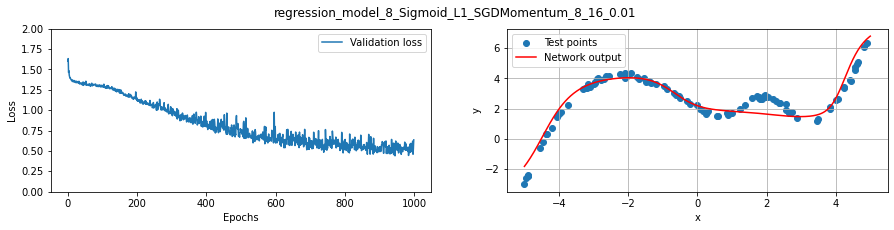

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________42/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.01, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.75it/s]


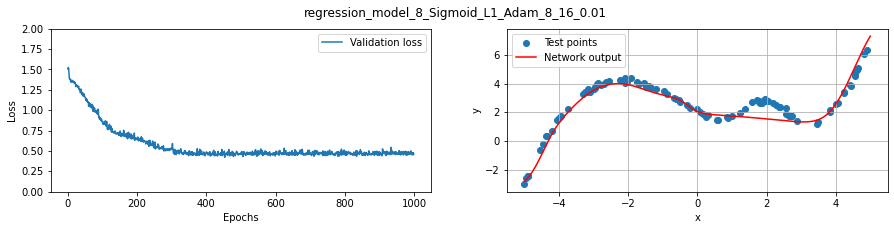

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________43/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.01, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.29it/s]


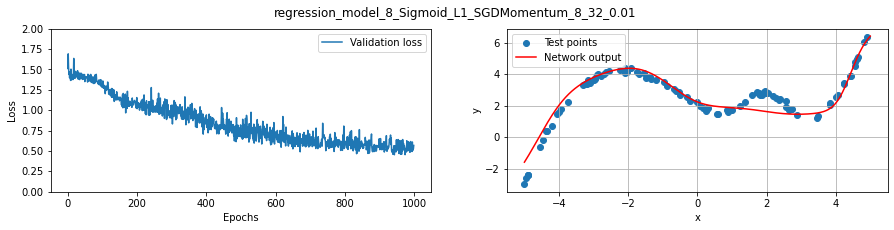

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________44/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.01, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.32it/s]


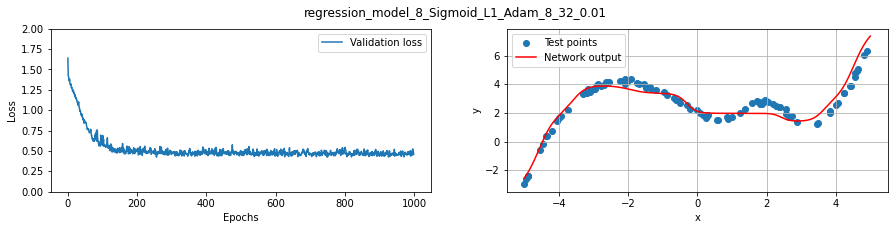

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________45/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.007, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.69it/s]


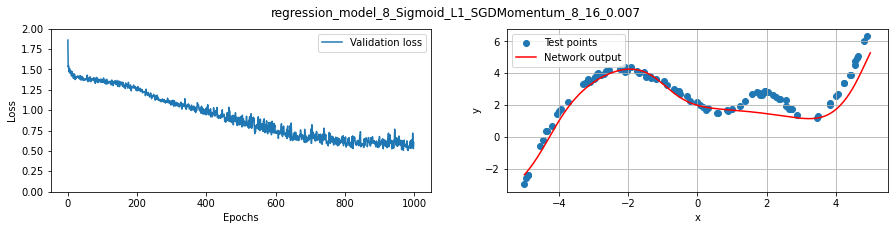

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________46/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.007, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 54.96it/s]


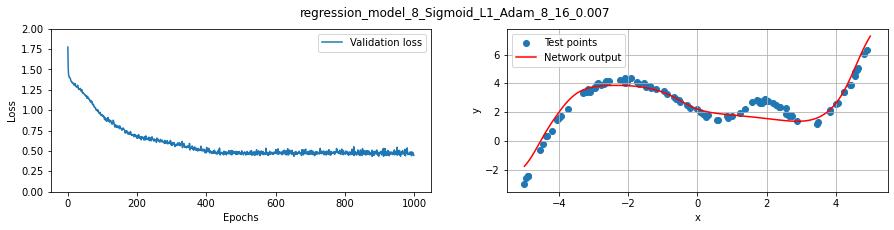

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________47/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.007, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 68.50it/s]


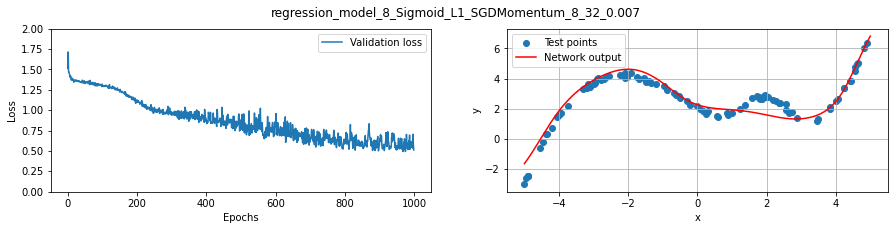

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________48/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.007, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 53.83it/s]


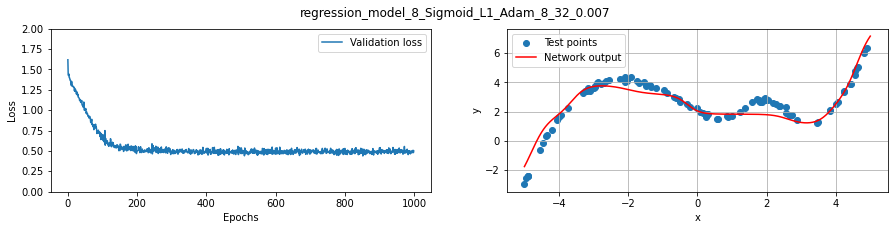

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________49/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.004, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.29it/s]


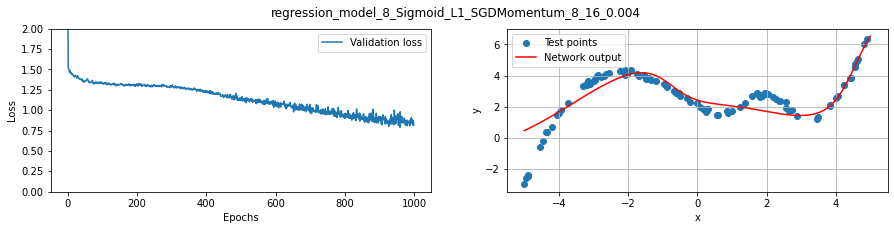

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________50/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.004, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.33it/s]


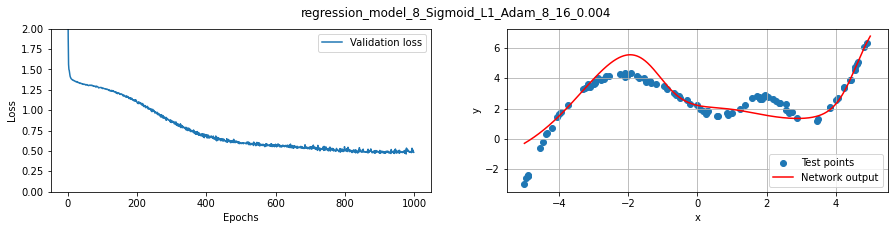

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________51/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.004, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 70.11it/s]


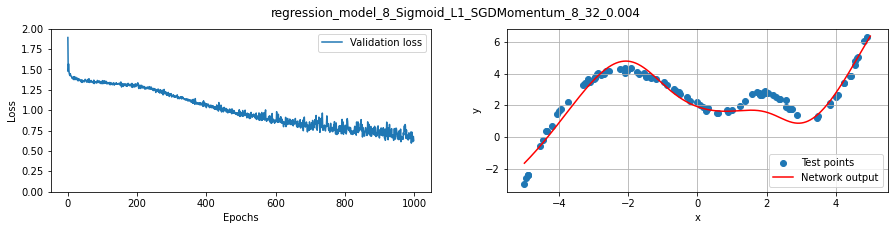

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________52/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.004, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.12it/s]


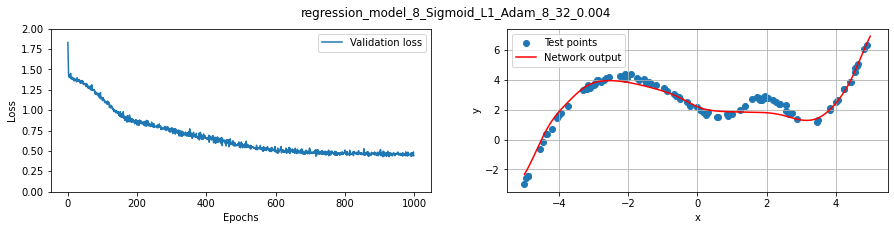

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________53/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.001, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 70.09it/s]


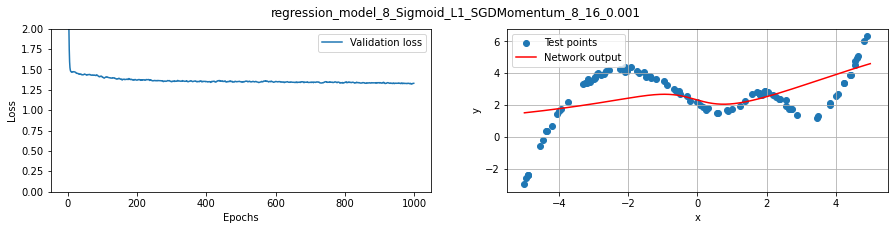

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________54/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.001, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 54.81it/s]


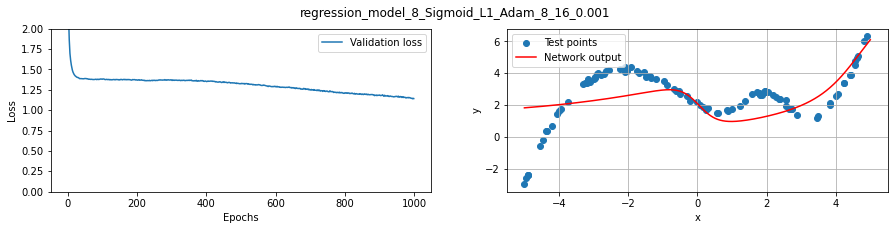

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________55/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.001, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.48it/s]


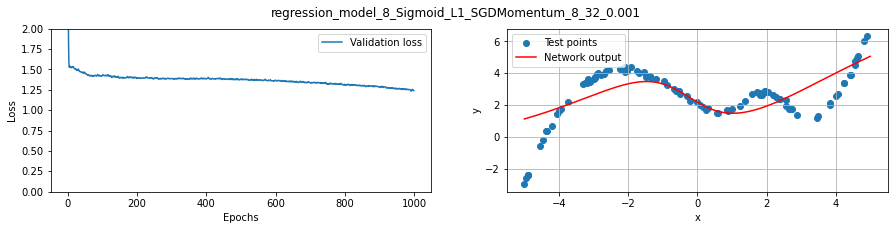

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________56/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.001, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.48it/s]


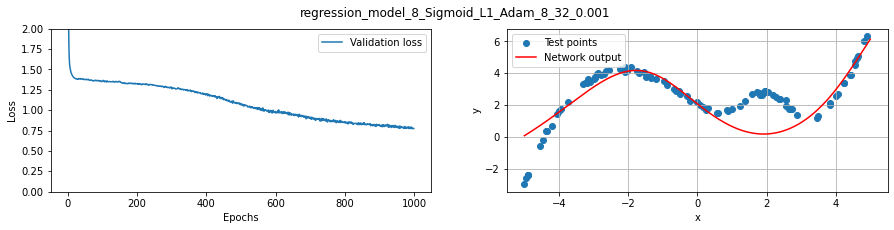

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________57/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.0008, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 68.71it/s]


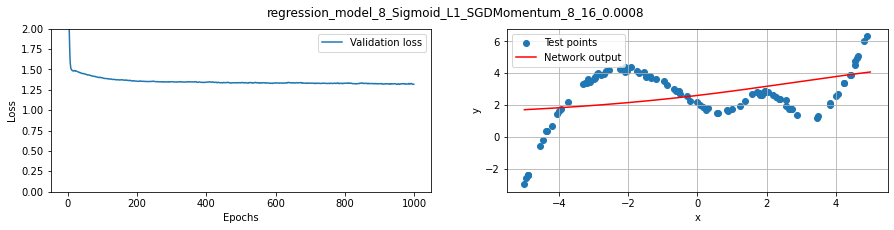

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________58/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.0008, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.08it/s]


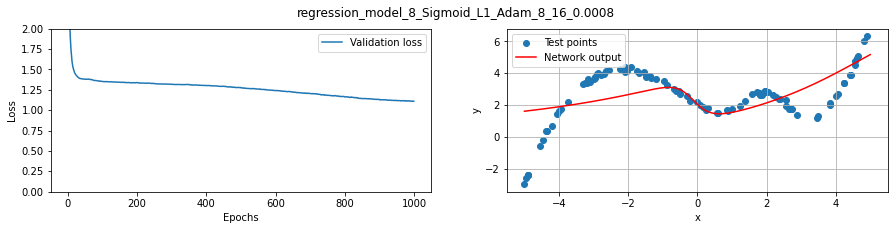

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________59/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.0008, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 69.79it/s]


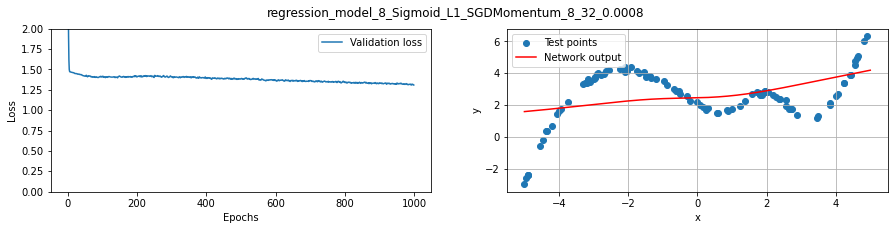

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________60/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: L1, lr: 0.0008, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:18<00:00, 55.31it/s]


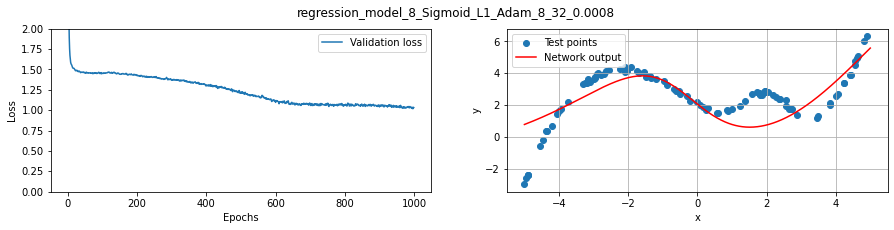

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________61/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.01, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.70it/s]


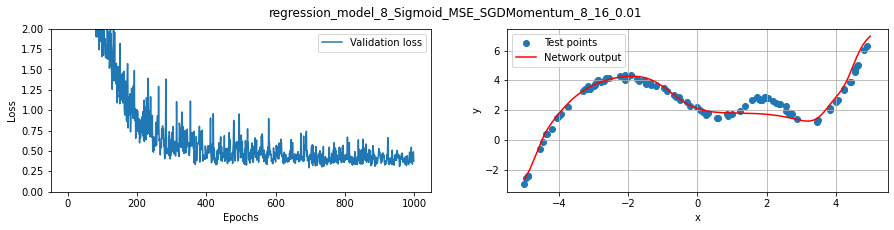

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________62/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.01, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.69it/s]


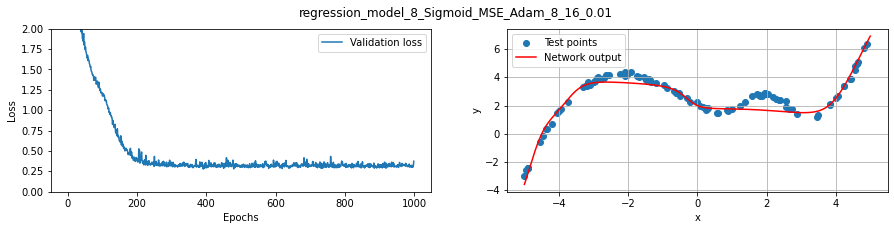

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________63/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.01, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 71.35it/s]


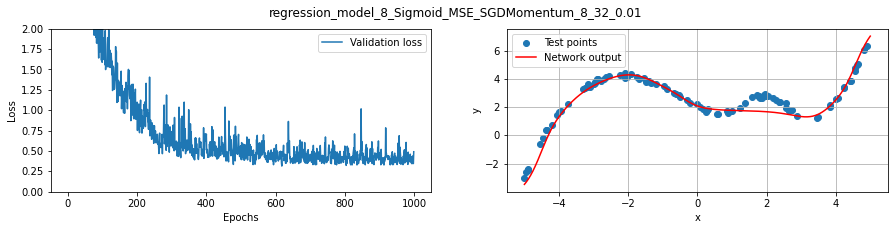

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________64/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.01, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.15it/s]


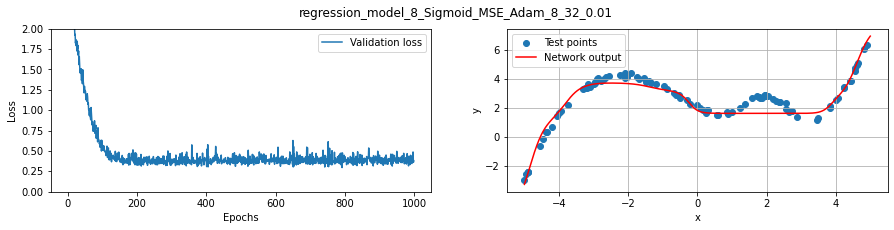

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________65/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.007, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.21it/s]


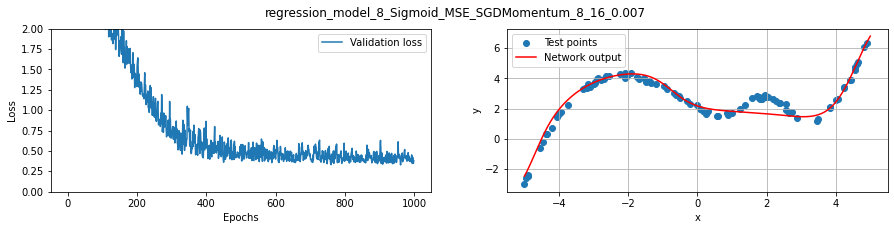

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________66/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.007, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.12it/s]


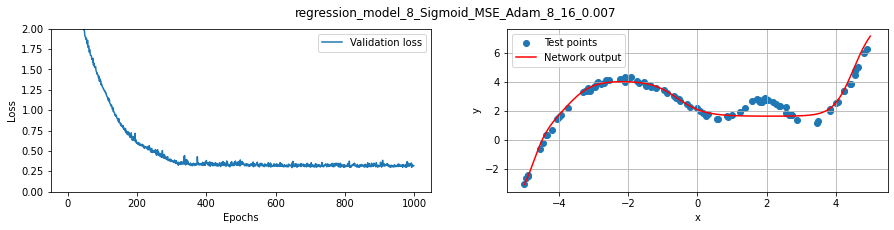

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________67/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.007, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 72.15it/s]


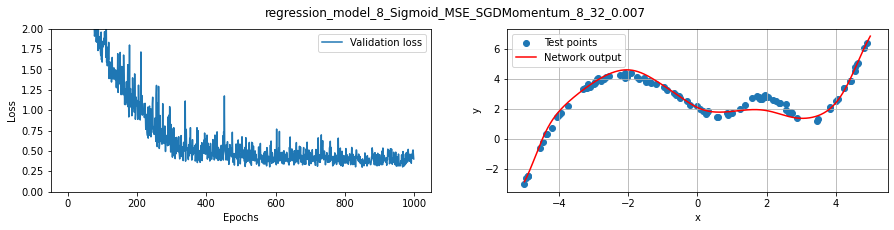

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________68/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.007, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.63it/s]


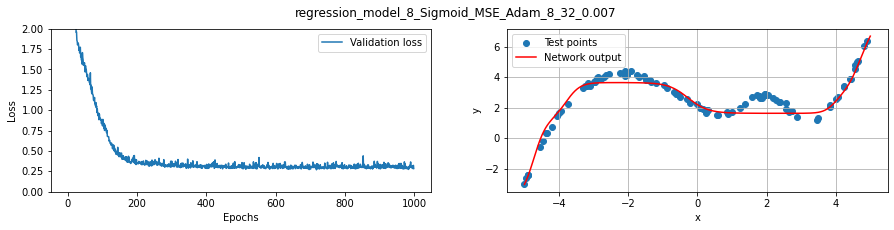

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________69/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.004, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 71.30it/s]


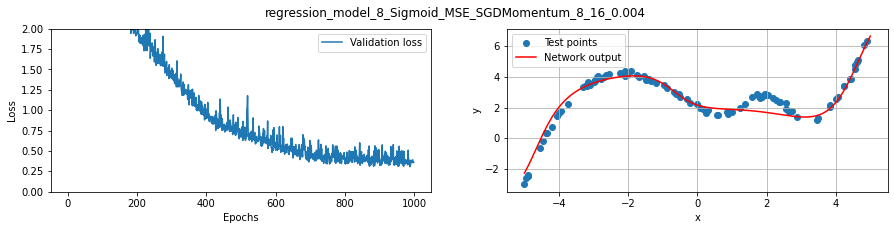

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________70/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.004, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 55.59it/s]


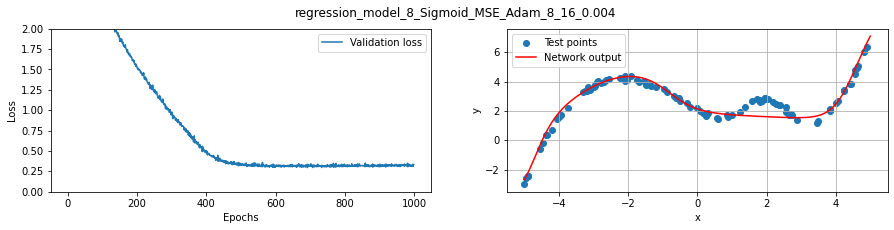

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________71/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.004, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.49it/s]


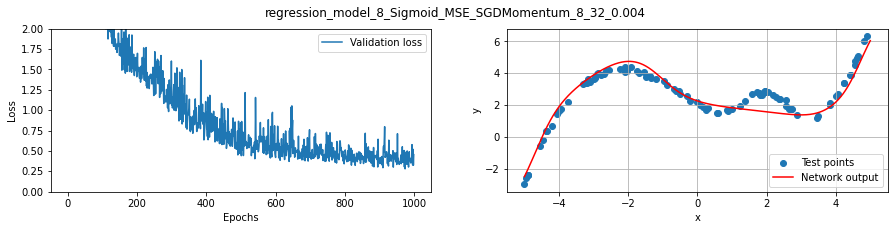

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________72/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.004, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.03it/s]


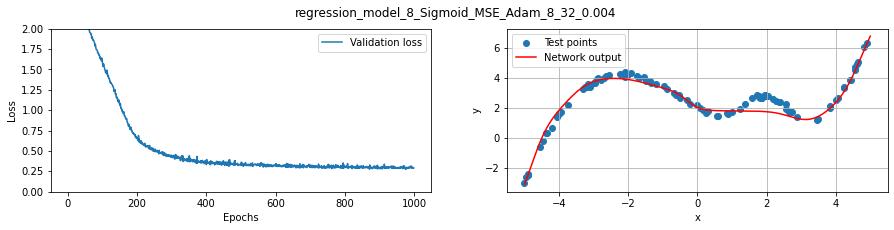

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________73/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.001, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 71.27it/s]


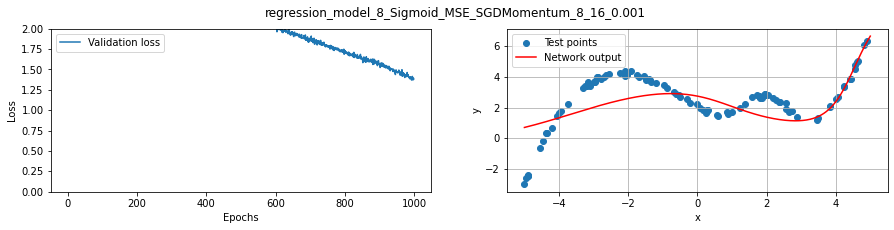

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________74/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.001, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.38it/s]


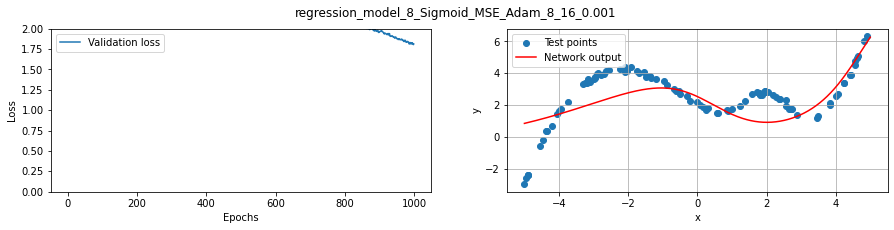

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________75/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.001, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.67it/s]


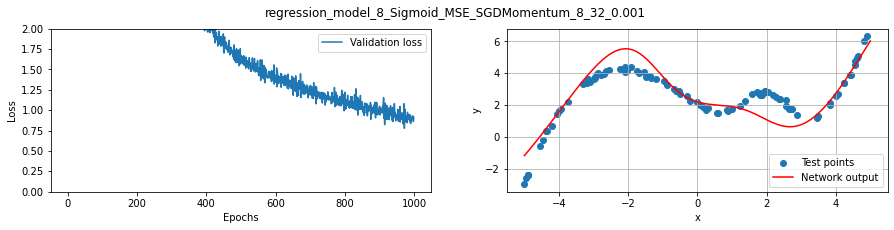

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________76/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.001, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.39it/s]


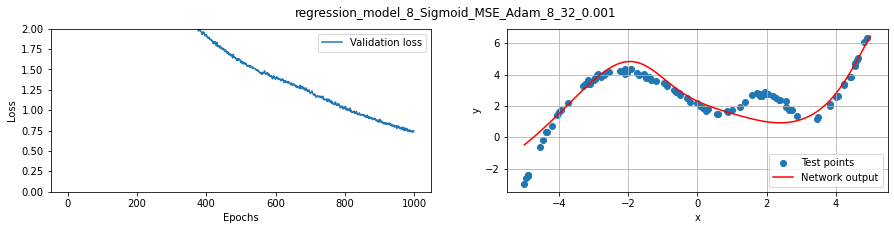

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________77/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.0008, hlayers: 16, opt: SGDMomentum


100%|██████████| 1000/1000 [00:13<00:00, 71.74it/s]


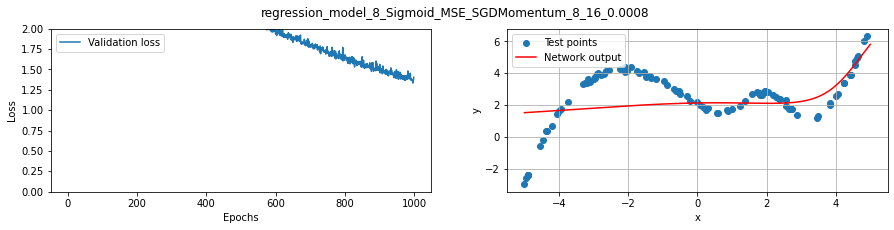

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________78/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.0008, hlayers: 16, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.11it/s]


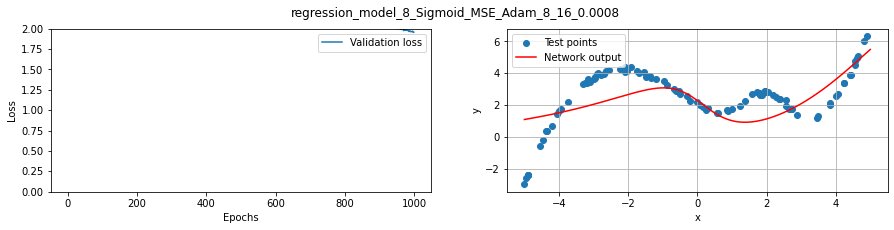

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________79/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.0008, hlayers: 32, opt: SGDMomentum


100%|██████████| 1000/1000 [00:14<00:00, 71.22it/s]


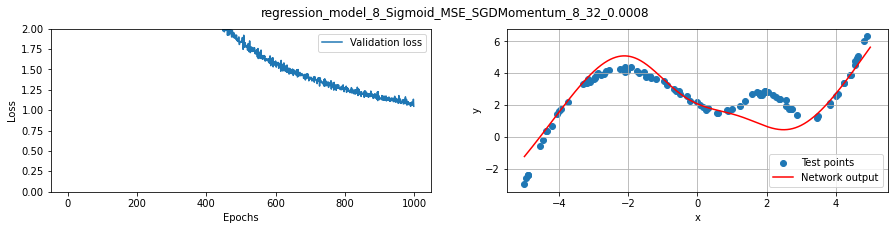

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


_____________________80/80____________________
bs: 8, act_fn: Sigmoid, loss_fn: MSE, lr: 0.0008, hlayers: 32, opt: Adam


100%|██████████| 1000/1000 [00:17<00:00, 56.35it/s]


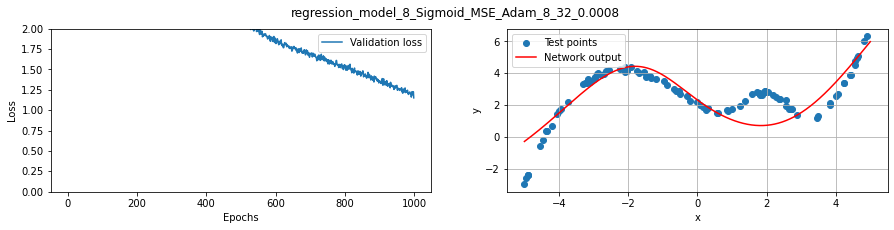

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
#train loop
losses = np.zeros((len(batch_sizes), len(activation_fns), len(loss_fns), len(learning_rates), len(hidden_layers), len(optimizers_strings), num_epochs))
num_tot_combinations = len(batch_sizes)*len(activation_fns)*len(loss_fns)*len(learning_rates)*len(hidden_layers)*len(optimizers_strings)
comb = 0
for a, batch_size in enumerate(batch_sizes):
    for b, (act_fn, act_fn_str) in enumerate(zip(activation_fns, activation_fns_strings)):
        for c, (loss_fn, loss_fn_str) in enumerate(zip(loss_fns, loss_fns_strings)):
            for d, lr in enumerate(learning_rates):
                for e, hidden_layer in enumerate(hidden_layers):
                    for f, optimizer_str in enumerate(optimizers_strings):
                        print(f"_____________________{comb+1}/{num_tot_combinations}____________________")
                        print(f"bs: {batch_size}, act_fn: {act_fn_str}, loss_fn: {loss_fn_str}, lr: {lr}, hlayers: {hidden_layer}, opt: {optimizer_str}")
                        comb+=1
                        # Create the model
                        net = Net(1, hidden_layer, hidden_layer, 1, activation_fn=act_fn,droput_rate=0)
                        #initialize the optimizer
                        optimizer = None
                        if optimizer_str == 'SGD':
                            optimizer = optim.SGD(net.parameters(), lr=lr)
                        elif optimizer_str == 'SGDMomentum':
                            optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
                        elif optimizer_str == 'Adam':
                            optimizer = optim.Adam(net.parameters(), lr=lr)
                        else:
                            print("Error, wrong optimizer")
                        # Define the loss function
                        loss_fn = loss_fn
                        # Train
                        kfold = KFold(n_splits=k_folds, shuffle=True)
                        combination_val_losses = np.zeros(num_epochs)
                        for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
                            # reset network parameters
                            reset_weights(net)
                            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                                            sampler=torch.utils.data.SubsetRandomSampler(train_ids))
                            val_dataloader = DataLoader(train_dataset, batch_size=256, 
                                            sampler=torch.utils.data.SubsetRandomSampler(val_ids))
                            train_loss_log, val_loss_log, net = train_model(net, train_dataloader, val_dataloader, 
                                            optimizer, loss_fn, num_epochs, enable_early_stopping=False)
                            combination_val_losses += np.array(val_loss_log)/k_folds
                            
                        #store the losses
                        losses[a,b,c,d,e,f,:] = combination_val_losses

                        #complete training on the full dataset
                        reset_weights(net)
                        dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                        _, _, net = train_model(net, dataloader, None, optimizer, loss_fn, num_epochs, enable_early_stopping=False)
                        #print the loss
                        model_name = 'regression_model_' + str(batch_size) + '_' + act_fn_str + '_' + loss_fn_str + '_' \
                                + optimizer_str + '_' + str(batch_size) + '_' + str(hidden_layer) + '_' + str(lr)
                        plot_save_losses_and_output(combination_val_losses, net, model_name)
                        # Save model
                        torch.save(net.state_dict(), 'training/' + model_name + '.pt')



# Notes
- using a big batch size (256), and training for a lot of epochs the model overfits, I therefore implemented early stopping in order to stop the training when the validation loss exceeds 20% of the minimum validation loss so far
- using a big batch size is not effective (with adam at least), it's better to use small batch sizes to achieve faster convergence
- I achieved very good results with 11k iterations (early stopped) 256 bs. lr 1e-3 adam mse. 
- Droput is very bad in this situation (why?)
- L1Loss works very well, much better than MSE, but needs more iterations
- HuberLoss also works well, but also needs more iterations

Optimizers:
- Adam is good lr around 5e-3, lower if we do more iterations
- SGD with momentum needs higher lr, 
- SGD without momentum bad
- RMSprop similar to Adam but slightly worse

Activation functions
- Relu is not smooth and it's not correct for this smooth function
- Tanh and Sigmoid give similar results, Tanh slightly better
- Softsign similar to Tanh but worse
- nn.Softplus() kinda good
- Softshrink a kinda smoother relu but still worse

Number of hidden layers
- 16/32 is a good number
- the bigger the number the faster the convergence, but the higher the risk of overfitting

Final Training

In [7]:
# ## TRAINING
torch.manual_seed(42)
net = Net(1, 16, 16, 1, activation_fn=nn.Tanh(),droput_rate=0)
# Define the loss function
loss_fn = nn.MSELoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=2e-3)
num_epochs = 4000
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# Train
train_loss_log, val_loss_log, net = train_model(net, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, enable_early_stopping=True)

 45%|████▌     | 1801/4000 [00:47<00:58, 37.65it/s]

Early stopping


### Plot losses

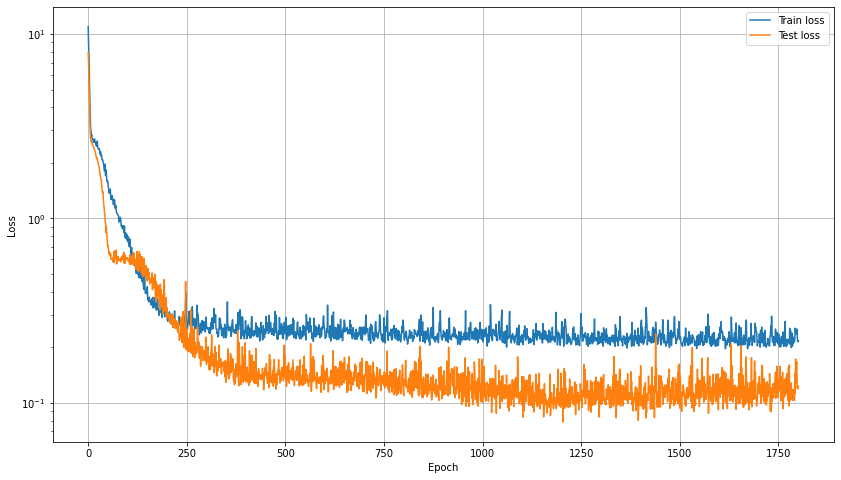

Final test loss: 0.12337546795606613


In [13]:
# Plot losses
plt.figure(figsize=(14,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

print(f"Final test loss: {val_loss_log[-1]}")

## Network analysis

### Network output

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


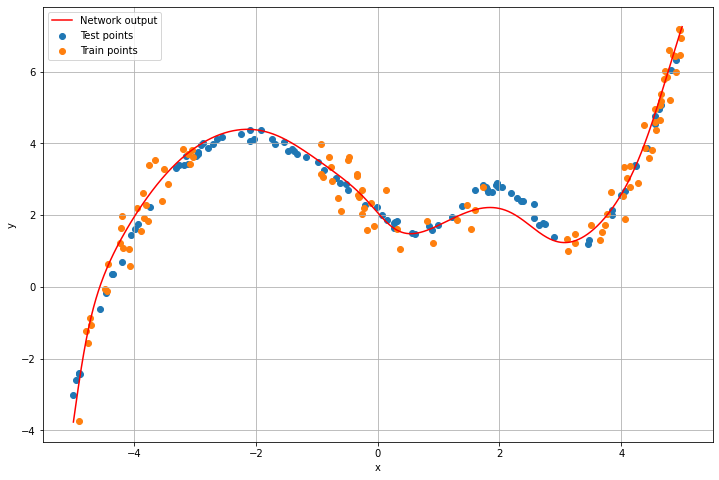

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
fig = plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output', color='red')
#show the points from the test dataset
plt.scatter(test_df.input, test_df.label, label='Test points')
#show the points from the train dataset
plt.scatter(train_df.input, train_df.label, label='Train points')

#plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()
#save the figure as eps
fig.savefig('images/final_regression_model_output.eps', format='eps', dpi=1000, bbox_inches='tight')

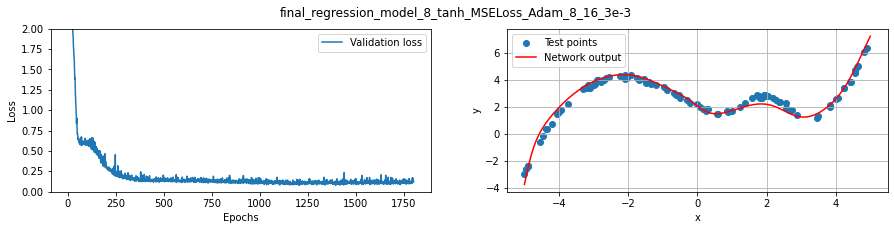

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
plot_save_losses_and_output(np.array(val_loss_log), net, 'final_regression_model_8_tanh_MSELoss_Adam_8_16_3e-3')

## Weight histograms and activation profiles

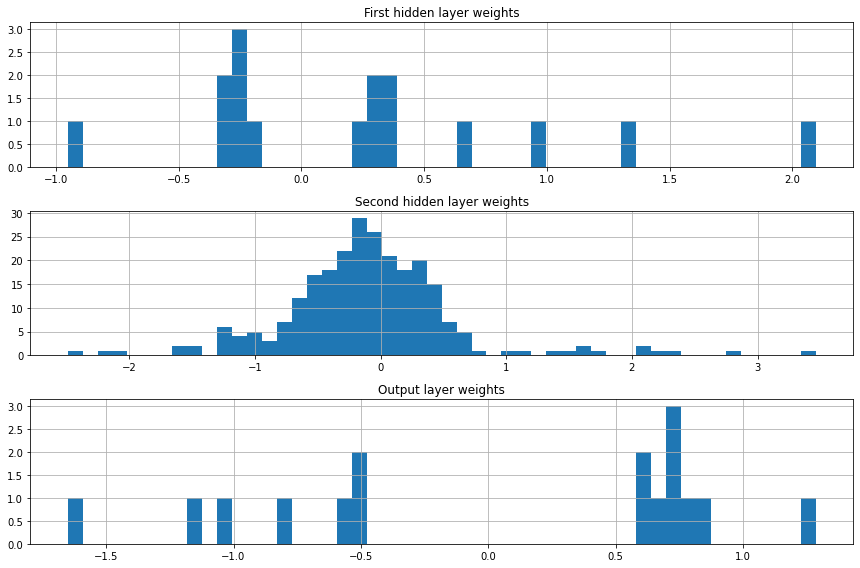

In [11]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()
#save fig as eps
fig.savefig('images/final_regression_model_weight_histograms.eps', format='eps', dpi=1000, bbox_inches='tight')

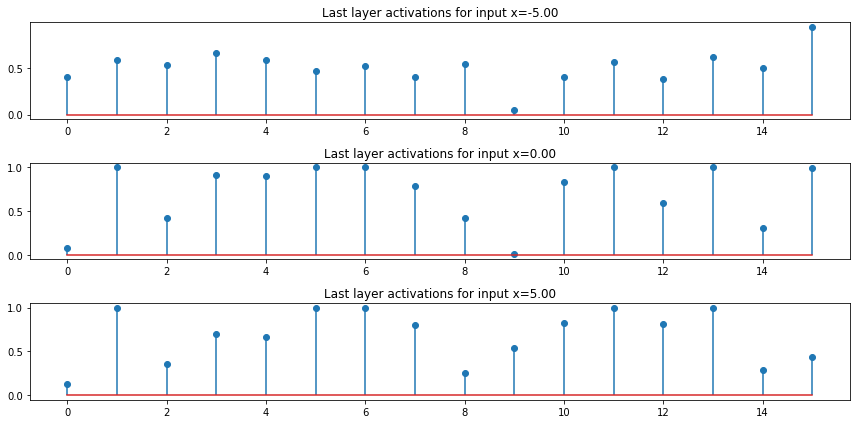

In [12]:
#using hooks
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-5]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()
#save fig as eps
fig.savefig('images/final_regression_model_activations.eps', format='eps', dpi=1000, bbox_inches='tight')